##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier


In [10]:
# read data from csv file
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

### Text Preprocessing

In [11]:
import nltk

#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

In [12]:
# data cleaning
X_train_raw = train_data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
X_train_raw = X_train_raw.apply(lambda x: re.sub(r'@[A-Za-z0-9]+', '', x))

X_test_raw = test_data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
X_test_raw = X_test_raw.apply(lambda x: re.sub(r'@[A-Za-z0-9]+', '', x))

#check the result
print("Test length:",len(X_test_raw))

Test length: 6099


### Training test splitting

In [13]:
# hold out with test size 0.3
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, Y_train, test_size=0.3, random_state=30)

In [14]:
# BoW 
BoW_vectorizer = CountVectorizer()
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)
X_test_BoW = BoW_vectorizer.transform(X_test_raw)
x_train_BoW = BoW_vectorizer.fit_transform(X_train)
x_test_BoW = BoW_vectorizer.transform(X_test)

In [ ]:
# fit into linear models
models = [DummyClassifier(strategy='most_frequent'),
          MultinomialNB(),
          LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression()]
titles = ['Zero-R',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    start = time.time()
    model.fit(x_train_BoW.todense(),y_train)
    end = time.time()
    t = end - start
    acc = model.score(x_test_BoW.todense(), y_test)
    print(title, "Accuracy:",acc, 'Time:', t)

Zero-R Accuracy: 0.5882892524078887 Time: 0.5393509864807129
MNB Accuracy: 0.6584620088671457 Time: 15.60637903213501
LinearSVC Accuracy: 0.6284971716862865 Time: 8.288414001464844


### Feature selecting

In [ ]:
# Tfidf Vectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(x_train)
tf_x_test = vectorizer.transform(x_test)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(tf_x_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(tf_x_test))))
    
mnb = MultinomialNB().fit(tf_x_train,y_train)
print(mnb.score(tf_x_test, y_test))

clf = LinearSVC(random_state=0)
clf.fit(tf_x_train,y_train)
print(clf.score(tf_x_test, y_test))

LogisticRegression(C=1).fit(tf_x_train,y_train)
print(LogisticRegression(C=1).score(tf_x_test, y_test))


#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

In [24]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train_raw)
tf_x_test = vectorizer.transform(X_test_raw)

model_lr = LogisticRegression(multi_class='ovr')
model_lr.fit(tf_x_train, Y_train)

prediction = model_lr.predict(tf_x_test.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index = test_data['id'])
pre.index.name='id'
pre.to_csv(r"tfidf_prediction_cv.csv")

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'negative']


In [40]:
# apply k best on tfidf 
kbest = SelectKBest(chi2, k=500).fit(tf_x_train, y_train)
kbest_train_X = kbest.transform(tf_x_train)
kbest_test_X = kbest.transform(tf_x_test)

mnb = MultinomialNB().fit(kbest_train_X,y_train)
print(mnb.score(kbest_test_X, y_test))

clf = LinearSVC(random_state=0)
clf.fit(kbest_train_X,y_train)
print(clf.score(kbest_test_X, y_test))

final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(kbest_train_X,y_train)
print(final_tfidf.score(kbest_test_X, y_test))

0.6034858387799564
0.6634560256851278
0.6556587547299622


In [ ]:
# save the created vocabulary for the given dataset in a separate file
vocab_dict = BoW_vectorizer.vocabulary_
output_pd = pd.DataFrame(list(vocab_dict.items()),columns = ['word','count'])
output_pd.T.to_csv('BoW-vocab.csv',index=False)

In [ ]:
# apply k best on BoW 
kbest = SelectKBest(chi2, k=500).fit(X_train_BoW, Y_train)
kbest_train_X = kbest.transform(X_train_BoW)
kbest_test_X = kbest.transform(X_test_BoW)

# training dataset
kbest = SelectKBest(chi2, k=700).fit(x_train_BoW, y_train)
kbest_train_x = kbest.transform(x_train_BoW)
kbest_test_x = kbest.transform(x_train_BoW)

x_train = kbest_train_x
x_test = kbest_test_x
X_train = kbest_train_X
X_test = kbest_test_X

### Model Adapting

In [ ]:
# Use the 10_fold_Cross_Validation with 4 models(LinearSVC, Decision Tree, KNN, Logistic Regression)
models = [LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(),
          LogisticRegression()]
titles = ['LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, x_train, y_train, cv=20))
    end = time.time()
    t = end - start
    print(title, "Accuracy:", acc, 'time:', t)
    
for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, x_test, y_test, cv=20))
    end = time.time()
    t = end - start
    print(title, "Accuracy:", acc, 'time:', t)

In [ ]:
from sklearn.model_selection import validation_curve, learning_curve
param_range = np.logspace (-2, 2, 10)
train_scores, valid_scores = validation_curve(LinearSVC(), x_train, y_train, param_name='C', 
                                              param_range=param_range, cv=5, n_jobs=-1, verbose=10)

In [ ]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)
std_valid_scores = np.std(valid_scores, axis=1)

In [ ]:
plt.semilogx(param_range, mean_train_scores, label="Training score", color='red')
plt.fill_between(param_range, mean_train_scores - std_train_scores,
                 mean_train_scores + std_train_scores, alpha=0.2, color="red")

plt.semilogx (param_range, mean_valid_scores, label="cross validation score", color='blue')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores,
mean_valid_scores + std_valid_scores, alpha=0.2, color="blue")

plt.legend(loc='best')
plt.title ("Validation curve for hyperparameter C in LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()

best_C = param_range[mean_valid_scores.argmax()]
best_C

In [ ]:
# use grid search find optimal c for logistic regression
from sklearn.model_selection import GridSearchCV
param_lr = {'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
            'multi_class':['multinomial','ovr'],
           }
gs_lr = GridSearchCV(LogisticRegression(),param_lr,cv=5, n_jobs=1, verbose=11)
print ("Performing grid search...")
print ("parameters:")
print (param_lr)
    
gs_lr.fit(x_test,y_test)
print ("Best score: 40. 3f" % gs_lr.best_score_)
print ("Best parameters set:")
           
best_param_lr = gs_lr.best_estimator_.get_params()
    
for param_name in sorted (param_lr.keys()) :
    print ("\t%s: %r" % (param_name, best_param_lr[param_name]))

In [ ]:
lr_scores = gs_lr.cv_results_['mean_test_score'].reshape(7,2)
sns.heatmap(lr_scores, xticklabels = param_lr['multi_class'], yticklabels=param_lr['C'], cmap='Blues')

b, t= plt. ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt. ylim(b, t) # update the ylim(bottom, top) values
plt. title ("Grid Search results of Logistic Regression")
plt.xlabel ("multi class")
plt.ylabel ("C")
plt.show ()

In [ ]:
# logistic heatmap
lr = LogisticRegression(C=1).fit(x_train, y_train)
lr_pred = lr.predict(x_test)

matrix_lr = confusion_matrix(y_test, lr_pred)
print(classification_report(y_test, lr_pred))
sns.heatmap(matrix_lr, cmap = 'Blues', annot = True, fmt = 'd')
plt.title("Logistic Regression confusion matrix and heatmap")
plt.xlabel ("Predicted classes")
plt.ylabel ("Actual classes")

### Ensemble models

In [22]:
#voting
base_classifiers = [('sgd', SGDClassifier()),
                    ('dt', DecisionTreeClassifier()),
                    ('lr', LogisticRegression(C=1, multi_class='multinomial')),
                    ('mnb' , MultinomialNB()),
                    (' svc', LinearSVC(C=10))]
voting = VotingClassifier(estimators=base_classifiers, voting='hard')
voting.fit(x_train, y_train)
print("voting accuracy")
cross_val_score(voting, x_train, y_train, cv=5).mean(),voting.score(x_test, y_test)


voting accuracy


(0.6777410355025394, 0.673291545635224)

In [ ]:
# bagging
DT = DecisionTreeClassifier()
bagging_one = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=10,\
                              max_samples=1.0, max_features=1.0)
bagging_two = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=10,\
                              max_samples=0.5, max_features=1.0)
bagging_three = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=10,\
                              max_samples=0.5, max_features=0.5)

DT.fit(x_train,y_train)
bagging_one.fit(x_train,y_train)
bagging_two.fit(x_train,y_train)
bagging_three.fit(x_train,y_train)

print("DT:",DT.score(x_test,y_test))
print("Option 1: bagging Accuracy:",bagging_one.score(x_test,y_test))
print("Option 2: bagging Accuracy:",bagging_two.score(x_test,y_test))
print("Option 3: bagging Accuracy:",bagging_three.score(x_test,y_test))

In [ ]:
from sklearn.ensemble import VotingClassifier
#voting
base_classifiers = [('sgd', SGDClassifier()),
                    ('dt', DecisionTreeClassifier()),
                    ('lr', LogisticRegression(C=0.5, multi_class='multinomial')),
                    ('mnb' , MultinomialNB()),
                    (' svc', LinearSVC(C=10))]
voting = VotingClassifier(estimators=base_classifiers, voting='hard')

voting.fit(kbest_train_X.todense(), Y_train)

prediction = voting.predict(kbest_test_X.todense())
#print("Stacker predict done")

print(prediction)
pre = pd.DataFrame(prediction, columns=['sentiment'], index = test_data['id'])
pre.index.name='id'
pre.to_csv(r"voting_prediction_cv.csv")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.6266483201467722


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.601880518289187
[[ 349 1013  118]
 [ 383 4056  649]
 [  58 1251  844]]
0.6320376103657838


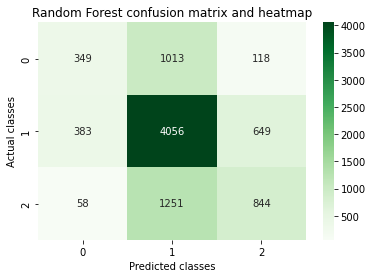

In [72]:
#random forest
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, verbose=1).fit(x_train, y_train)
print(rf.score(x_test, y_test))

rf = RandomForestClassifier(n_jobs=-1, n_estimators=10, verbose=1).fit(x_train, y_train)
print(rf.score(x_test, y_test))

rf_pred = rf.predict(x_test)
matrix_rf = confusion_matrix(y_test, rf_pred)

print(matrix_rf)
sns.heatmap(matrix_rf, cmap = 'Greens', annot = True, fmt = 'd')
plt.title("Random Forest confusion matrix and heatmap")
plt.xlabel ("Predicted classes")
plt.ylabel ("Actual classes")


#ada
ada = AdaBoostClassifier().fit(x_train,y_train)
print(ada.score(x_test, y_test))

In [ ]:
# stacking code from prac 8
np.random.seed(1)

class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X)
        self.metaclassifier.fit(X_meta, y)
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0]
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

In [ ]:
# base calssifier to be chosen # lr/multinomial
classifiers = [LogisticRegression(),
                MultinomialNB()]
titles = ['Logistic Regression',
          'Multinomial NB']

# three meta classifiers
meta_classifier_lr = LogisticRegression(C=1)
stacker_lr = StackingClassifier(classifiers, meta_classifier_lr)

meta_classifier_mnb = MultinomialNB()
stacker_mnb = StackingClassifier(classifiers, meta_classifier_mnb)

meta_classifier_svc = LinearSVC(C=10)
stacker_svc = StackingClassifier(classifiers, meta_classifier_svc)

In [ ]:
start = time.time()
print("im running")
stacker_lr.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_lr = stacker_lr.score(x_test.todense(), y_test)
print('\nStacker Accuracy (Logistic Regression):', acc_lr, 'Time:', t)


start = time.time()
stacker_mnb.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_mnb = stacker_mnb.score(x_test.todense(), y_test)
print('\nStacker Accuracy (Multinomial Regression):', acc_mnb, 'Time:', t)


start = time.time()
stacker_svc.fit(x_train.todense(), y_train)
end = time.time()
t = end - start
acc_svc = stacker_svc.score(x_test.todense(), y_test)
print('\nStacker Accuracy (LinearSVC):', acc_svc, 'Time:', t)


### Prediction

In [50]:
stacker_lr.fit(kbest_train_X.todense(), Y_train)
stacker_svc.fit(kbest_train_X.todense(), Y_train)

prediction = stacker_svc.predict(kbest_test_X.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index = test_data['id'])
pre.index.name='id'
pre.to_csv(r"svc_stacker_prediction_cv.csv")

prediction = stacker_lr.predict(kbest_test_X.todense())
pre = pd.DataFrame(prediction, columns=['sentiment'], index = test_data['id'])
pre.index.name='id'
pre.to_csv(r"lr_stacker_prediction_cv.csv")

['negative' 'negative' 'neutral' ... 'neutral' 'positive' 'negative']
['negative' 'negative' 'neutral' ... 'neutral' 'positive' 'negative']
